### Library import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import tensorflow as tf
import math
from matplotlib.pyplot import figure

plt.rcParams["figure.figsize"] = (6,6)

#
from sklearn.model_selection import train_test_split


#---- CNN model libraries ----
import keras 
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras import callbacks
from keras import backend as K
from keras.models import load_model

In [2]:
def get_distance(p1, p2):
    """
    Description: Function to return the Eucledian distance between 2 points
    Input: p1: First point with coordinates x1,y1
            p2: Second point with coordinates x2,y2
    Output: Eucleadian distance between p1 and p2
    """
    x2 = p2[0]
    x1 = p1[0]
    y2 = p2[1]
    y1 = p1[1]
    dist = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    
    return dist

In [3]:
#Define metric functions
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [4]:
def get_detection_accuracy(real_obj, predicted_obj):
    #constant. Max possible detection range of the system
    max_range = 1.54
    temp_acc = []
    #for  every real object
    for object_to_evaluate in real_obj:
        temp_dist = []
        #if no predicted objects, return accuracy of 0
        if len(predicted_obj) == 0:
            temp_acc.append(0)
        else:
            #for every predicted object
            for object_to_compare in predicted_obj:
                #get the distance between real object and predicted objects
                temp_dist.append(get_distance(df_coords.iloc[object_to_evaluate,:].values,
                                             df_coords.iloc[object_to_compare,:].values))
            #keep the min distance     
            min_temp_dist = min(temp_dist)
            #calculate the accuracy for the given object
            temp_acc.append(1.0 - min_temp_dist/max_range)
    
    #calculate the overall detection accuracy using the distances
    distance_accuracy = sum(temp_acc)/len(temp_acc)
    #calculate the overall detection accuracy using the number of detected objects
    number_accuracy = 1 - (np.abs(len(predicted_obj)-len(real_obj))/len(real_obj))
    #average of the two accuracy values
    overall_accuracy = (distance_accuracy + number_accuracy) / 2

    return overall_accuracy

### Dataset import

In [5]:
df_features = pd.read_csv('datasets/features_2.csv')
df_labels = pd.read_csv('datasets/labels_2.csv')
df_coords = pd.read_csv('datasets/coords.csv')
print('Feature Dataset shape: ', df_features.shape)
print('\nLabels Dataset shape:', df_labels.shape)

Feature Dataset shape:  (17066, 243)

Labels Dataset shape: (17066, 161)


Separate dataset into train/test sets

In [6]:
X_train, X_test, y_train, y_test = train_test_split(df_features.iloc[:,:].values,
                                                    df_labels.iloc[:,:].values,
                                                    test_size = 0.25,
                                                    random_state = 0)

### Model architecture

In [7]:
df_features.shape[1]

243

In [42]:
classifier =  Sequential()

#Hidden layer 1 - Input layer
classifier.add( Dense(units = df_features.shape[1], kernel_initializer = 'he_uniform', activation = 'relu') )

#Hidden layer 3
classifier.add( Dense(units = 128, kernel_initializer = 'he_uniform', activation = 'relu') )
#Hidden layer 4
classifier.add( Dense(units = 90, kernel_initializer = 'he_uniform', activation = 'relu') )
#Hidden layer 5
classifier.add( Dense(units = 128, kernel_initializer = 'he_uniform', activation = 'relu') )


#Output layer
classifier.add( Dense(units = df_labels.shape[1], activation = 'sigmoid') )

Optimizer setup

In [43]:
learning_rate = 0.001
beta1 = 0.9
beta2 = 0.999
epsilon = 1e-08
decay = 0.0
epochs = 50

opt = keras.optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=learning_rate/epochs)

CNN compile using the Adam optimizer and Binary crossentropy as loss function and accuracy as main metric.

In [44]:
#opt = SGD(lr=0.01, momentum=0.9)
classifier.compile( optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy', f1_m])

In [45]:
#ANN training 
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 15, 
                                        restore_best_weights = True)


history = classifier.fit(X_train, y_train,
                         epochs = 50,
                        validation_data=(X_test, y_test),
                        callbacks =[earlystopping])

Epoch 1/50
400/400 [==============================] - 6s 14ms/step - loss: 0.1855 - accuracy: 0.0363 - f1_m: 0.0117 - val_loss: 0.0579 - val_accuracy: 0.1966 - val_f1_m: 0.2754
Epoch 2/50
400/400 [==============================] - 5s 13ms/step - loss: 0.0490 - accuracy: 0.2509 - f1_m: 0.4156 - val_loss: 0.0373 - val_accuracy: 0.2864 - val_f1_m: 0.5784
Epoch 3/50
400/400 [==============================] - 5s 14ms/step - loss: 0.0335 - accuracy: 0.3066 - f1_m: 0.6107 - val_loss: 0.0324 - val_accuracy: 0.3098 - val_f1_m: 0.6216
Epoch 4/50
400/400 [==============================] - 4s 11ms/step - loss: 0.0290 - accuracy: 0.3127 - f1_m: 0.6550 - val_loss: 0.0300 - val_accuracy: 0.3347 - val_f1_m: 0.6396
Epoch 5/50
400/400 [==============================] - 4s 11ms/step - loss: 0.0264 - accuracy: 0.3085 - f1_m: 0.6791 - val_loss: 0.0285 - val_accuracy: 0.3222 - val_f1_m: 0.6496
Epoch 6/50
400/400 [==============================] - 4s 11ms/step - loss: 0.0246 - accuracy: 0.3188 - f1_m: 0.6934

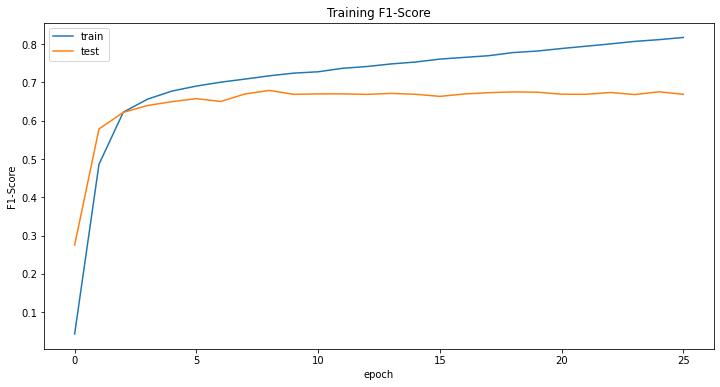

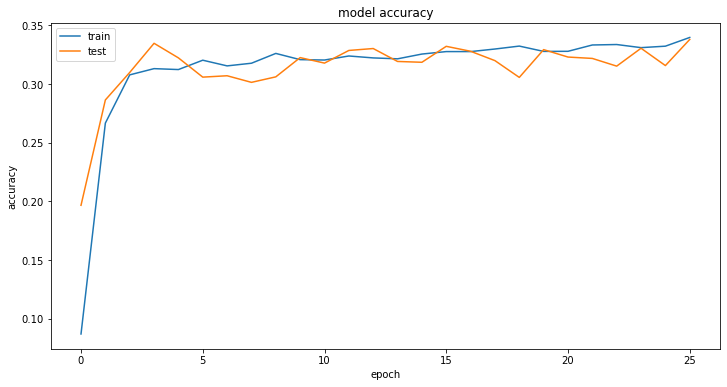

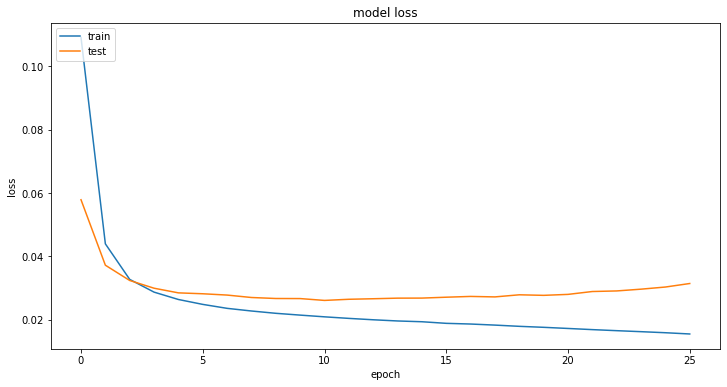

In [46]:
plt.plot(history.history['f1_m'])
plt.plot(history.history['val_f1_m'])
plt.title('Training F1-Score')
plt.ylabel('F1-Score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#f1-score
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Save/load model

In [20]:
#save trained model to the following path
path_to_save = 'models/model_v2.h5'
classifier.save(path_to_save)

In [19]:
#load model from path
path_to_load = 'models/model_v2.h5'
#define needed dependecies to load the model
dependencies = {
    'f1_m': f1_m
}
#load the model
classifier = load_model(path_to_load, custom_objects=dependencies)

### Predictions - Validation data

In [10]:
df_val_features = pd.read_csv('datasets/test_features.csv')
df_val_labels = pd.read_csv('datasets/test_labels.csv')

In [11]:
X_val = df_val_features.iloc[:,:].values
y_val = df_val_labels.iloc[:,:].values

In [12]:
#define a threshold value 
threshold = 0.4
#ANN prediction
y_pred = classifier.predict(X_val)
#keep predictions above the threshold
y_pred = (y_pred > threshold)

2022-02-16 16:27:36.463414: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-02-16 16:27:36.485405: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 1999965000 Hz


In [13]:
validation_accuracy = []
for prediction_index in range(len(y_pred)):
    #load the predicted and real quadrants for the test dataset
    predicted_quadrant = np.argwhere(np.isin(y_pred[prediction_index], True)).ravel()
    real_quadrant = np.argwhere(np.isin(y_test[prediction_index], True)).ravel()
    
    prediction_accuracy = get_detection_accuracy(real_obj= real_quadrant,
                                                 predicted_obj= predicted_quadrant)
    validation_accuracy.append(prediction_accuracy)
print('Overall accuracy: ', sum(test_accuracy)/len(test_accuracy))

NameError: name 'test_accuracy' is not defined

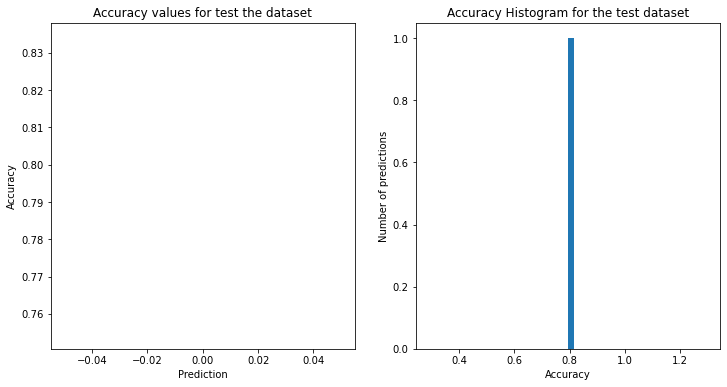

In [14]:
plt.rcParams["figure.figsize"] = (12,6)

plt.subplot(1,2,1)
plt.title('Accuracy values for test the dataset')
plt.plot(list(range(y_pred.shape[0])),
                     validation_accuracy, color = 'orange')
plt.xlabel('Prediction')
plt.ylabel('Accuracy')


plt.subplot(1,2,2)
plt.title('Accuracy Histogram for the test dataset')
plt.xlabel('Accuracy')
plt.ylabel('Number of predictions')
plt.hist(validation_accuracy, bins=50)
plt.show()

In [ ]:
index = 0

print('Real object quadrant: ',
      np.argwhere(np.isin(y_val[index], True)).ravel())
print('\nPredicted object quadrant: ',
      np.argwhere(np.isin(y_pred[index], True)).ravel())

Real object quadrant:  [ 0 17 42 68 92]

Predicted object quadrant:  [  1  67 160]


### Predictions - test dataset

In [20]:
#define a threshold value 
threshold = 0.40
#ANN prediction
y_pred = classifier.predict(X_test)
#keep predictions above the threshold
y_pred = (y_pred > threshold)

In [21]:
index = 1011

print('Real object quadrant: ',
      np.argwhere(np.isin(y_test[index], True)).ravel())
print('\nPredicted object quadrant: ',
      np.argwhere(np.isin(y_pred[index], True)).ravel())

Real object quadrant:  [ 48 129]

Predicted object quadrant:  [ 48 108]


In [22]:
test_accuracy = []
for prediction_index in range(len(y_pred)):
    #load the predicted and real quadrants for the test dataset
    predicted_quadrant = np.argwhere(np.isin(y_pred[prediction_index], True)).ravel()
    real_quadrant = np.argwhere(np.isin(y_test[prediction_index], True)).ravel()
    
    prediction_accuracy = get_detection_accuracy(real_obj= real_quadrant,
                                                 predicted_obj= predicted_quadrant)
    test_accuracy.append(prediction_accuracy)
print('Overall accuracy: ', sum(test_accuracy)/len(test_accuracy))

Overall accuracy:  0.8564663940692905


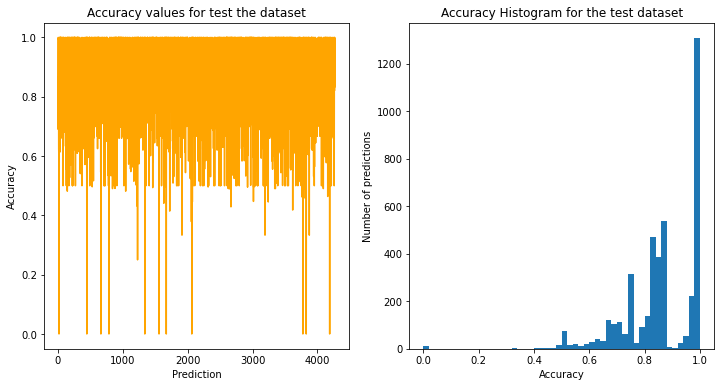

In [23]:
plt.rcParams["figure.figsize"] = (12,6)

plt.subplot(1,2,1)
plt.title('Accuracy values for test the dataset')
plt.plot(list(range(y_pred.shape[0])),
                     test_accuracy, color = 'orange')
plt.xlabel('Prediction')
plt.ylabel('Accuracy')


plt.subplot(1,2,2)
plt.title('Accuracy Histogram for the test dataset')
plt.xlabel('Accuracy')
plt.ylabel('Number of predictions')
plt.hist(test_accuracy, bins=50)
plt.show()

In [39]:
index = 3827

print('Real object quadrant: ',
      np.argwhere(np.isin(y_test[index], True)).ravel())
print('\nPredicted object quadrant: ',
      np.argwhere(np.isin(y_pred[index], True)).ravel())

Real object quadrant:  [ 39  43  69 113]

Predicted object quadrant:  []


In [36]:
#get all the indexes of the predictions that belongs to the same accuracy number -> target accuracy
target_acc = 0
indexes = [i for i,x in enumerate(test_accuracy) if x == target_acc]
indexes

[15, 444, 661, 785, 1338, 1557, 1669, 2062, 3775, 3827, 4188]